In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
wine = pd.read_csv("/content/winequality-red.csv")  # Upload to Colab first
print(wine.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [3]:
print("\nMissing values:\n", wine.isnull().sum())  # Verify no missing data
print("\nData types:\n", wine.dtypes)


Missing values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Data types:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [11]:
print(wine.head())  # Should match your first screenshot
print(wine.shape)   # Should be (1599, 12)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [12]:
print(wine.duplicated().sum())  # Should be 0 or you'll need wine.drop_duplicates()

240


# Correlation Heatmap

In [8]:
wine = wine.loc[:, ~wine.columns.duplicated()]  # Remove duplicate columns

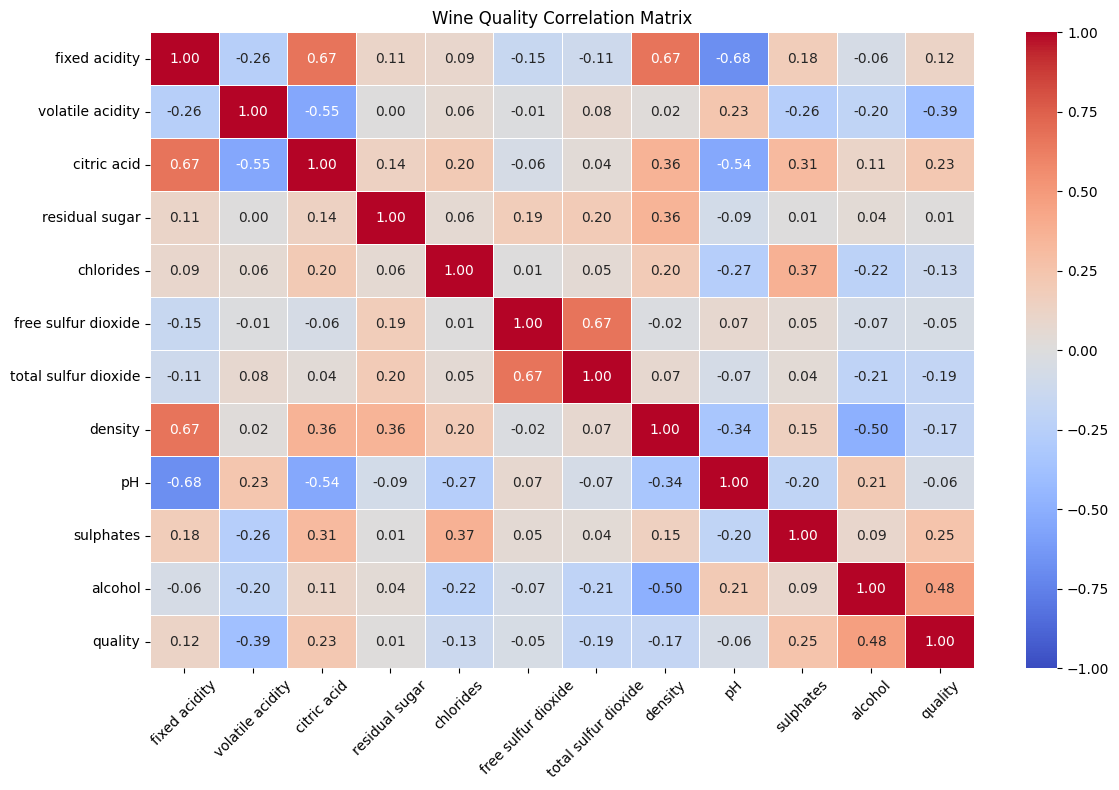

In [10]:
plt.figure(figsize=(12, 8))
corr = wine.corr()  # Calculate correlation first

# Create the heatmap
sns.heatmap(corr,
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            annot_kws={"size": 10},
            vmin=-1, vmax=1)  # Force scale from -1 to 1

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Wine Quality Correlation Matrix")
plt.tight_layout()
plt.savefig("corrected_correlation.png")
plt.show()

# Feature Engineering

In [13]:
# 1. Alcohol-to-acidity ratio (often impacts taste)
wine['alcohol_acidity_ratio'] = wine['alcohol'] / (wine['fixed acidity'] + 1e-6)  # +1e-6 prevents division by zero

# 2. Sulfur dioxide ratio (affects preservation)
wine['so2_ratio'] = wine['free sulfur dioxide'] / (wine['total sulfur dioxide'] + 1e-6)

# 3. Sugar-to-alcohol ratio (indicates fermentation)
wine['sugar_alcohol_ratio'] = wine['residual sugar'] / (wine['alcohol'] + 1e-6)

# Verify new features
print(wine[['alcohol_acidity_ratio', 'so2_ratio', 'sugar_alcohol_ratio']].head())

   alcohol_acidity_ratio  so2_ratio  sugar_alcohol_ratio
0                1.27027   0.323529             0.202128
1                1.25641   0.373134             0.265306
2                1.25641   0.277778             0.234694
3                0.87500   0.283333             0.193878
4                1.27027   0.323529             0.202128


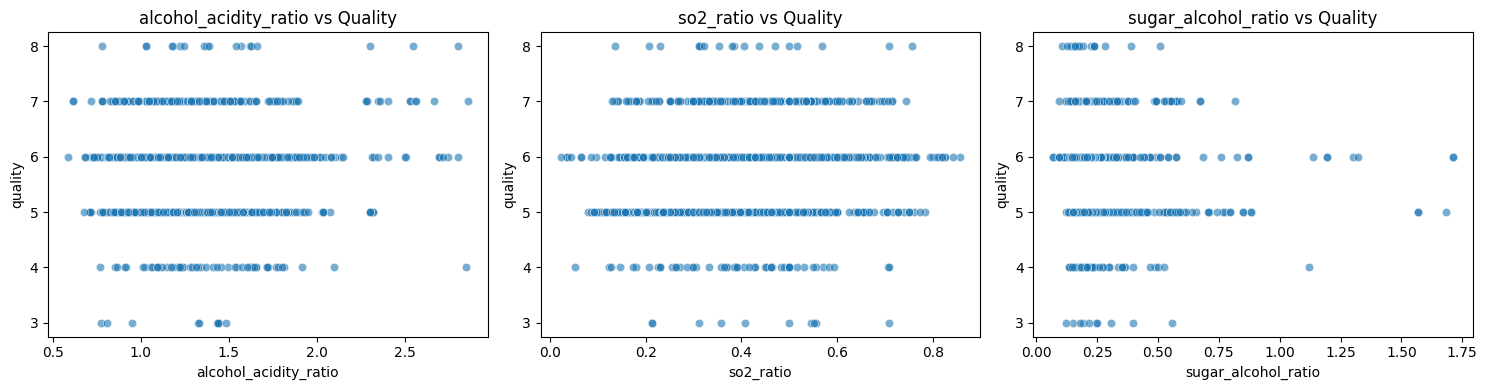

In [14]:
plt.figure(figsize=(15, 4))
for i, col in enumerate(['alcohol_acidity_ratio', 'so2_ratio', 'sugar_alcohol_ratio']):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=col, y='quality', data=wine, alpha=0.6)
    plt.title(f"{col} vs Quality")
plt.tight_layout()
plt.savefig("new_features.png")
plt.show()

In [17]:
# 1. Verify new features
print(wine[['alcohol_acidity_ratio', 'so2_ratio', 'sugar_alcohol_ratio']].head())

   alcohol_acidity_ratio  so2_ratio  sugar_alcohol_ratio
0                1.27027   0.323529             0.202128
1                1.25641   0.373134             0.265306
2                1.25641   0.277778             0.234694
3                0.87500   0.283333             0.193878
4                1.27027   0.323529             0.202128


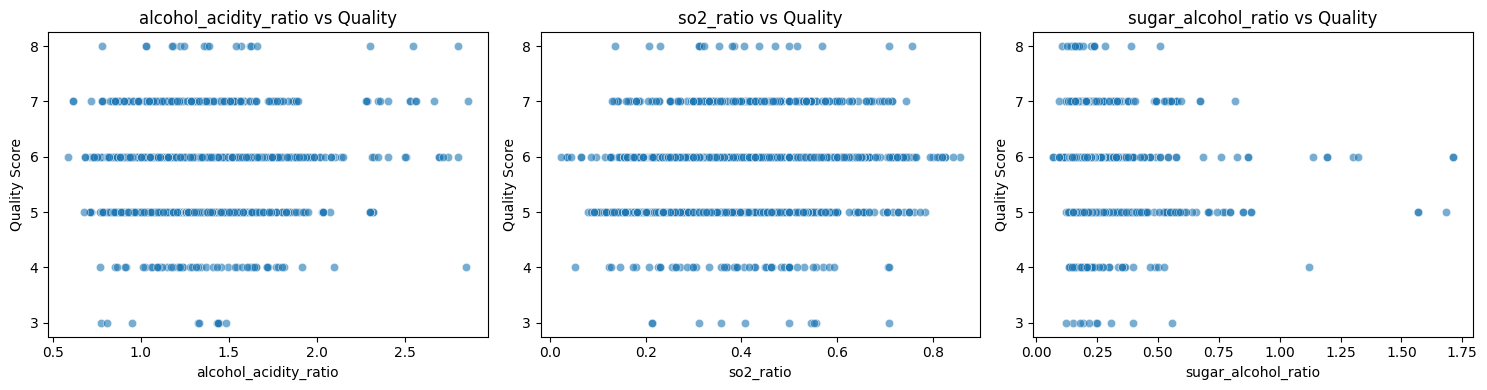

In [16]:
plt.figure(figsize=(15, 4))
features = ['alcohol_acidity_ratio', 'so2_ratio', 'sugar_alcohol_ratio']
for i, col in enumerate(features, 1):  # Start subplot index at 1
    plt.subplot(1, 3, i)
    sns.scatterplot(x=col, y='quality', data=wine, alpha=0.6)
    plt.title(f"{col} vs Quality", fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Quality Score", fontsize=10)
plt.tight_layout()
plt.savefig("new_features.png", dpi=300, bbox_inches='tight')
plt.show()

# Model Training

In [18]:
# Include new features
X = wine.drop('quality', axis=1)
y = wine['quality']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

# Model Evaluation

In [21]:
from sklearn.metrics import r2_score, mean_squared_error

# Predictions
y_pred = model.predict(X_test)

# Metrics (FIXED)
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")  # Manual RMSE calculation

# Feature Importance (FIXED variable name 'x' -> 'X')
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 5 Features:")
print(feature_imp.head(5))

R² Score: 0.525
RMSE: 0.557

Top 5 Features:
alcohol                 0.265021
sulphates               0.144145
volatile acidity        0.100191
total sulfur dioxide    0.064331
so2_ratio               0.061266
dtype: float64


In [22]:
import joblib

# Save model
joblib.dump(model, 'wine_quality_model.pkl')

# Save feature names
import json
with open('feature_names.json', 'w') as f:
    json.dump(list(X.columns), f)